In [16]:
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

from Siamese_model import SiameseTrainer

from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
def load_and_preprocess_image(path, target_size=(96, 96)):
    img = load_img(path, target_size=target_size, color_mode='grayscale')
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Normalize to [0,1]
    return img

def load_pairs_and_labels(csv_path, image_base_path):
    df = pd.read_csv(csv_path)
    pair_images = []
    labels = df['label'].values
    
    for idx, row in df.iterrows():
        img1_path = os.path.join(image_base_path, row['image_1'])
        img2_path = os.path.join(image_base_path, row['image_2'])
        
        img1 = load_and_preprocess_image(img1_path)
        img2 = load_and_preprocess_image(img2_path)
        
        pair_images.append(np.concatenate([img1, img2], axis=0))
    
    # Convert list of pairs to a numpy array
    pairs = np.array(pair_images)
    
    # Since each image pair is concatenated along axis=0, we reshape to ensure
    # the final structure is compatible with what train_model expects
    pairs = pairs.reshape(-1, 2, *pairs.shape[2:])
    
    return pairs, labels


In [3]:
def new_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        BatchNormalization(),
        Dropout(0.25),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [4]:
input_shape = (96, 96, 1)
num_classes = 3

In [5]:
model_new = new_model(input_shape, num_classes)

In [6]:
# Define path for quater dataset
image_base_path = '../OpenSARShip/Categories/'

train_csv_path = os.getcwd() + "/Split_quater_siamese/train_pairs.csv"
val_csv_path = os.getcwd() + "/Split_quater_siamese/val_pairs.csv"
test_csv_path = os.getcwd() + "/Split_quater_siamese/test_pairs.csv"

# Load and preprocess the data
print("Loading and preprocessing the data train")
train_pairs, train_labels = load_pairs_and_labels(train_csv_path, image_base_path)
print("Loading and preprocessing the data val")
val_pairs, val_labels = load_pairs_and_labels(val_csv_path, image_base_path)
print("Loading and preprocessing the data test")
test_pairs, test_labels = load_pairs_and_labels(test_csv_path, image_base_path)

Loading and preprocessing the data train
Loading and preprocessing the data val
Loading and preprocessing the data test


Creating the SiameseTrainer
Compiling the model
Training the model
Epoch 1/2
383/383 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5467
Epoch 1: val_accuracy improved from -inf to 0.55298, saving model to Siam_batch32_quater_data_new_model.pth
INFO:tensorflow:Assets written to: Siam_batch32_quater_data_new_model.pth\assets


INFO:tensorflow:Assets written to: Siam_batch32_quater_data_new_model.pth\assets


383/383 [==============================] - 175s 456ms/step - loss: 0.6908 - accuracy: 0.5467 - val_loss: 0.6884 - val_accuracy: 0.5530
Epoch 2/2
383/383 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5480
Epoch 2: val_accuracy did not improve from 0.55298
383/383 [==============================] - 123s 322ms/step - loss: 0.6888 - accuracy: 0.5480 - val_loss: 0.6878 - val_accuracy: 0.5530
INFO:tensorflow:Assets written to: Siam_batch32_quater_data_new_model.pth\assets


INFO:tensorflow:Assets written to: Siam_batch32_quater_data_new_model.pth\assets


New best model with validation accuracy 0.5529752969741821 saved as Siam_batch32_quater_data_new_model.pth
Plotting the training history


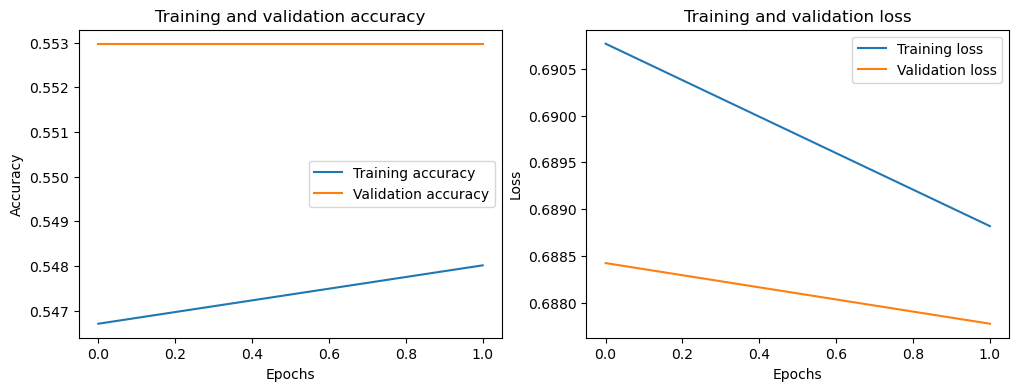

Evaluating the model
42/42 [==============================] - 2s 51ms/step - loss: 0.6822 - accuracy: 0.5860
Test accuracy:  0.5859728455543518


In [7]:
# Assuming `simple_cnn` and `SiameseTrainer` are defined as before
print("Creating the SiameseTrainer")
siamese_network = SiameseTrainer(base_model_func=new_model, input_shape=(96, 96, 1), num_classes=num_classes)
# siamese_network = SiameseTrainer(base_model_func=new_model, input_shape=(96, 96, 1), num_classes=num_classes)

# Set the optimizer
initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.96,
#     staircase=True)

optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
print("Compiling the model")
# siamese_network.compile_model(optimizer='adam', loss='binary_crossentropy')
siamese_network.compile_model(optimizer=optimizer, loss='binary_crossentropy')


# Train the model
print("Training the model")
# siamese_network.train_model(train_pairs, train_labels, val_pairs, val_labels, epochs=10, batch_size=32)
siamese_network.train_model(train_pairs, train_labels, val_pairs, val_labels, epochs=2, batch_size=32, model_save_name='Siam_batch32_quater_data_new_model.pth')


# Plot training history
print("Plotting the training history")
siamese_network.plot_training()

# Evaluate the model
print("Evaluating the model")
siamese_network.evaluate_model(test_pairs, test_labels)


In [8]:
# print(os.getcwd())
# print(os.path.join(os.getcwd(), '../OpenSARShip/Categories/'))
base_dir = os.path.abspath('../OpenSARShip/Categories/')
print(base_dir)

c:\Users\Julia\Projets_ENSTA\Projet_Systeme_3A\OpenSARShip\Categories


In [19]:
def get_category_from_path(file_path):
    # Extracts the category from the file path based on your directory structure
    category = file_path.split('\\')[0]
    return category


In [9]:
# Reference of the images
# image_base_path = '../OpenSARShip/Categories/'
image_base_path = os.path.abspath('../OpenSARShip/Categories/')

reference_images = {
    'Tanker' : [load_and_preprocess_image(image_base_path + '/Tanker/Tanker_Visual_Cargo_x6945_y4168_vv.tif'),
                load_and_preprocess_image(image_base_path + '/Tanker/Tanker_Visual_Cargo_x52546_y8377_vv.tif')],
    'Container Ship' : [load_and_preprocess_image(image_base_path + '/Container Ship/ContainerShip_Visual_Cargo_x186_y2504_vv.tif'),
                        load_and_preprocess_image(image_base_path + '/Container Ship/ContainerShip_Visual_Cargo_x215_y7247_vv.tif')],
    'Bulk Carrier' : [load_and_preprocess_image(image_base_path + '/Bulk Carrier/BulkCarrier_Visual_Cargo_x48_y7700_vv.tif'),
                      load_and_preprocess_image(image_base_path + '/Bulk Carrier/BulkCarrier_Visual_Cargo_x123_y5601_vv.tif')]
}

In [23]:
def classify_test_image(test_image, siamese_model, reference_images):
    highest_similarity = 0
    predicted_category = None
    
    for category, refs in reference_images.items():
        category_similarity = 0
        
        for ref_img in refs:
            # Ensure both test_image and ref_img are 4-dimensional
            # (1, Height, Width, Channels)
            similarity = siamese_model.predict([test_image, ref_img])[0][0]
            category_similarity += similarity
        
        # Calculate average similarity for this category
        category_similarity /= len(reference_images[category])
        
        if category_similarity > highest_similarity:
            highest_similarity = category_similarity
            predicted_category = category
            
    return predicted_category



In [24]:
test_df = pd.read_csv(os.path.join(os.getcwd(), 'Split_quater_siamese/test_pairs.csv'))


predictions = []
true_categories = []

for index, row in test_df.iterrows():
    # img1_path = os.path.join('OpenSARShip/Categories', row['image_1'])
    img1_path = os.path.join(os.path.abspath('../OpenSARShip/Categories'), row['image_1'])
    img1_category = get_category_from_path(row['image_1'])
    img1 = load_and_preprocess_image(img1_path)
    
    predicted_category = classify_test_image(img1, siamese_network.model, reference_images)
    
    predictions.append(predicted_category)
    true_categories.append(img1_category)

# Now you can calculate classification metrics based on `predictions` and `true_categories`


1/1 [==============================] - 0s 96ms/step


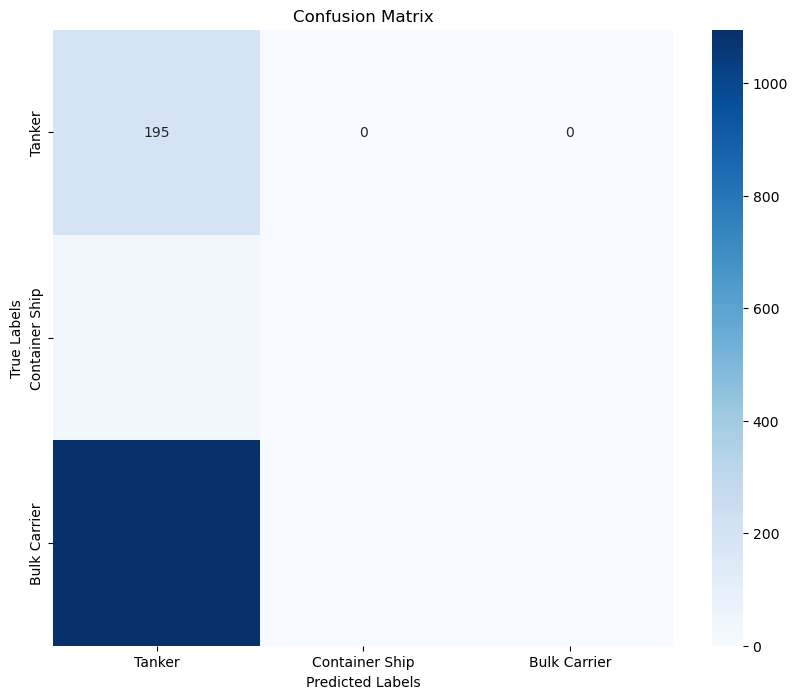

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming true_categories holds the true class labels, and predictions holds the predicted labels from your model
conf_matrix = confusion_matrix(true_categories, predictions, labels=list(reference_images.keys()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(reference_images.keys()), yticklabels=list(reference_images.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [26]:
print(classification_report(true_categories, predictions, target_names=list(reference_images.keys())))


                precision    recall  f1-score   support

        Tanker       0.00      0.00      0.00      1095
Container Ship       0.00      0.00      0.00        36
  Bulk Carrier       0.15      1.00      0.26       195

      accuracy                           0.15      1326
     macro avg       0.05      0.33      0.09      1326
  weighted avg       0.02      0.15      0.04      1326



c:\Users\Julia\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julia\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julia\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_categories, predictions)
print(f"Overall accuracy: {accuracy*100:.2f}%")

Overall accuracy: 14.71%


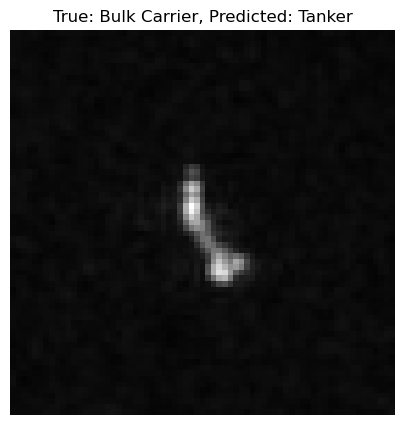

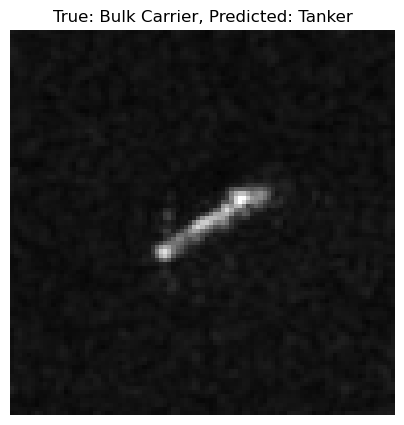

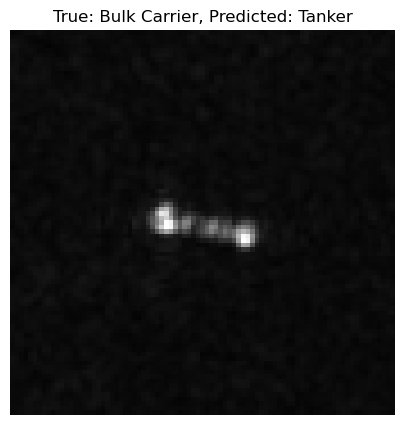

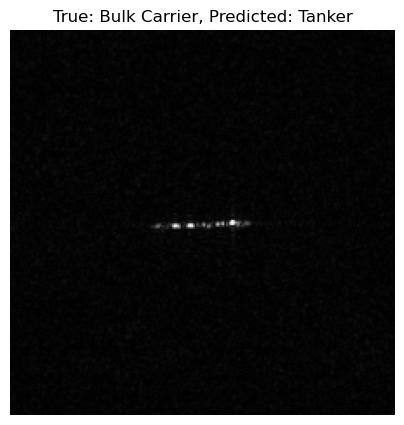

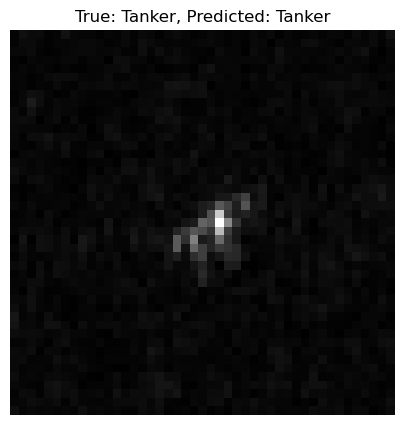

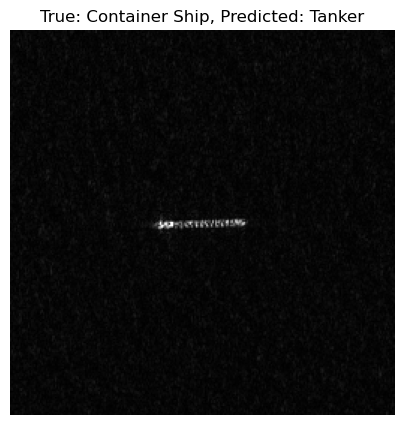

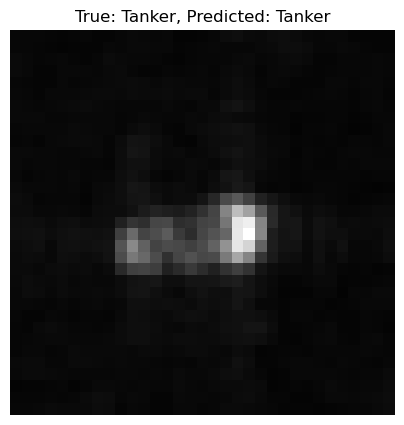

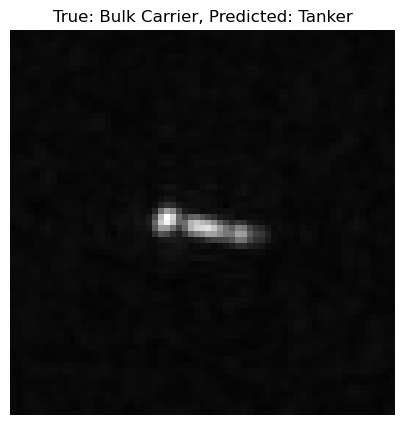

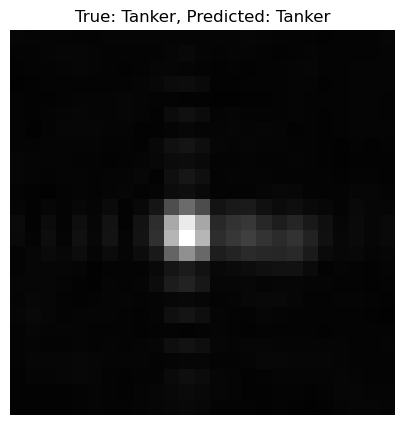

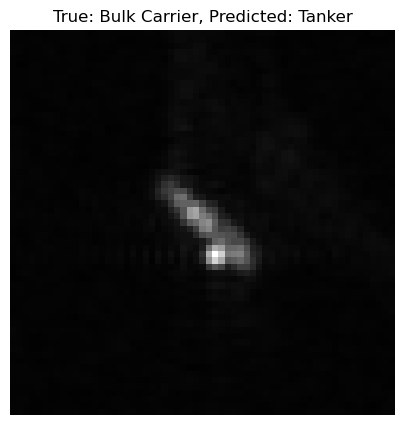

In [28]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Randomly select a few images
samples = random.sample(range(len(predictions)), 10)

for i in samples:
    img_path = os.path.join(image_base_path, test_df.iloc[i]['image_1'])
    img = load_img(img_path)
    true_label = true_categories[i]
    predicted_label = predictions[i]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()


In [29]:
from collections import Counter

# Assuming you have a list of predictions
prediction_counts = Counter(predictions)
print(prediction_counts)


Counter({'Tanker': 1326})


In [30]:
test_df = pd.read_csv(os.path.join(os.getcwd(), 'Split_Tanker_Bulk_Container_frugal_vv/test.csv'))
predictions = []
true_categories = []

for index, row in test_df.iterrows():
    # img1_path = os.path.join('OpenSARShip/Categories', row['image_1'])
    img1_path = os.path.join(os.path.abspath('../OpenSARShip/Categories'), row['file_path'])
    img1_category = get_category_from_path(row['file_path'])
    img1 = load_and_preprocess_image(img1_path)
    
    predicted_category = classify_test_image(img1, siamese_network.model, reference_images)
    
    predictions.append(predicted_category)
    true_categories.append(img1_category)

1/1 [==============================] - 0s 55ms/step


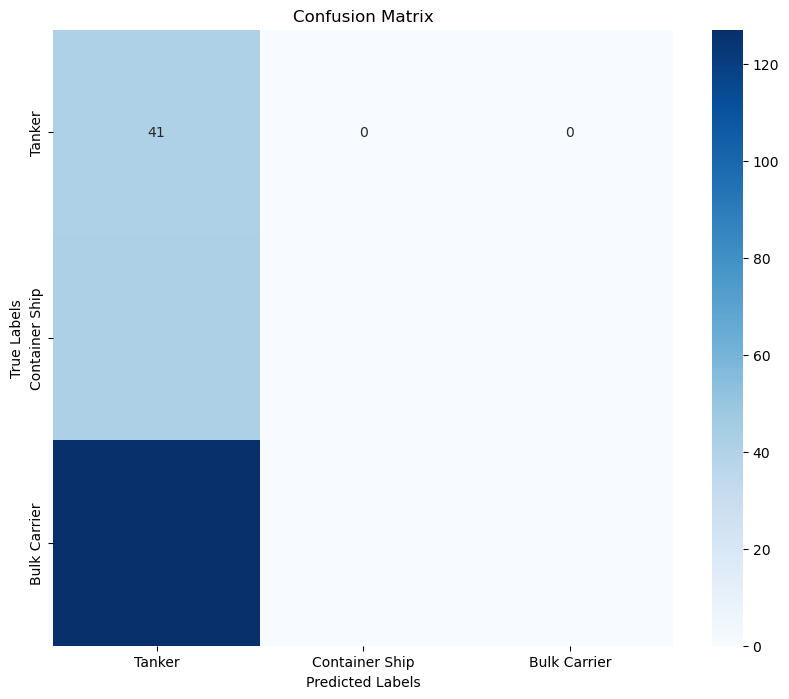

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming true_categories holds the true class labels, and predictions holds the predicted labels from your model
conf_matrix = confusion_matrix(true_categories, predictions, labels=list(reference_images.keys()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(reference_images.keys()), yticklabels=list(reference_images.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [32]:
print(classification_report(true_categories, predictions, target_names=list(reference_images.keys())))

                precision    recall  f1-score   support

        Tanker       0.00      0.00      0.00       127
Container Ship       0.00      0.00      0.00        42
  Bulk Carrier       0.20      1.00      0.33        41

      accuracy                           0.20       210
     macro avg       0.07      0.33      0.11       210
  weighted avg       0.04      0.20      0.06       210



c:\Users\Julia\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julia\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julia\anaconda3\envs\tensorflow_new\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

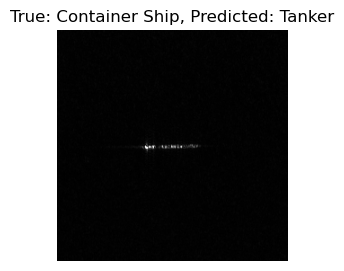

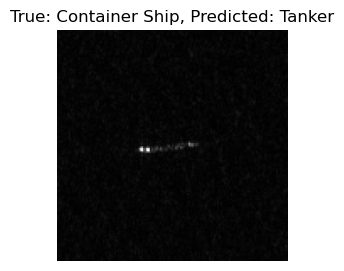

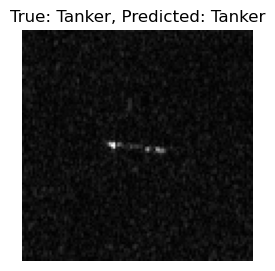

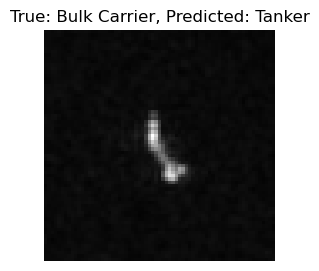

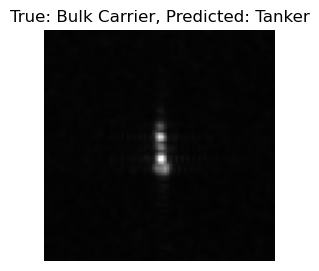

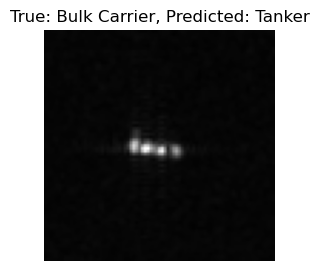

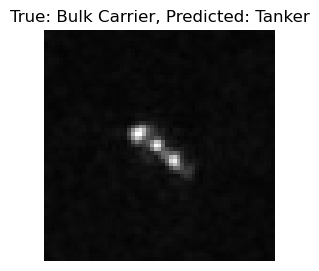

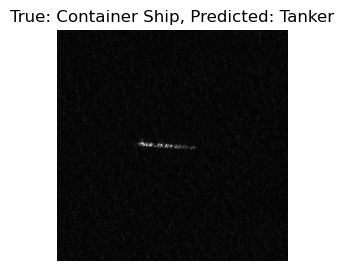

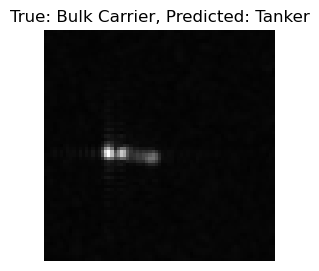

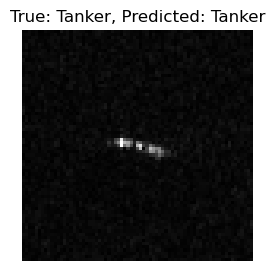

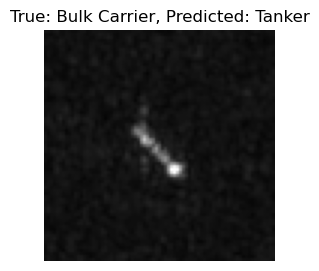

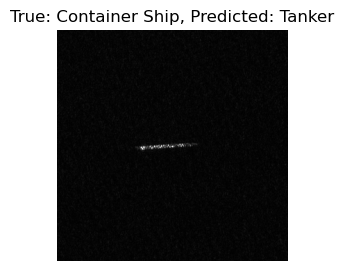

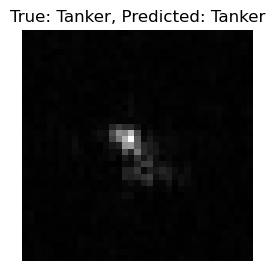

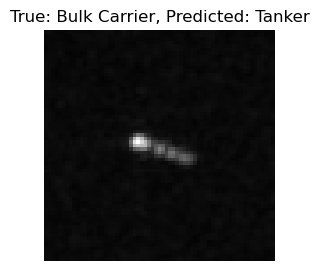

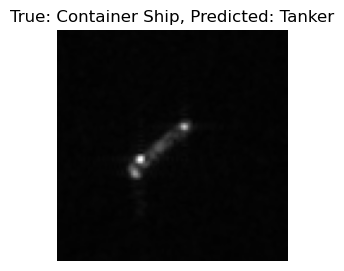

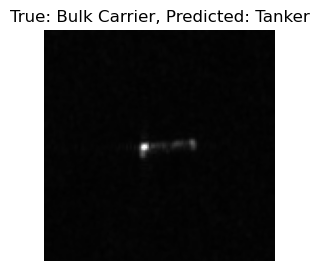

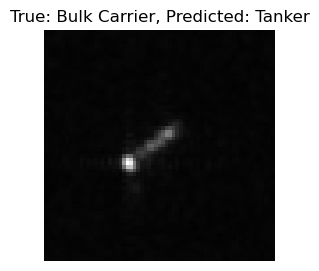

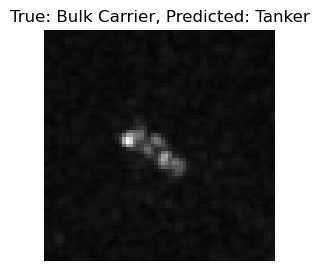

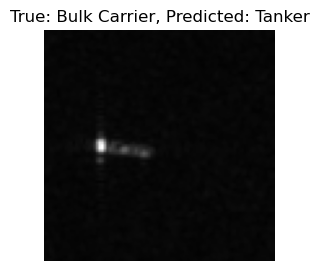

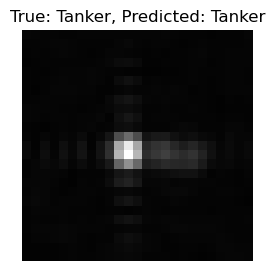

In [35]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Randomly select a few images
samples = random.sample(range(len(predictions)), 20)

for i in samples:
    img_path = os.path.join(image_base_path, test_df.iloc[i]['file_path'])
    img = load_img(img_path)
    true_label = true_categories[i]
    predicted_label = predictions[i]
    
    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

In [36]:
from collections import Counter

# Assuming you have a list of predictions
prediction_counts = Counter(predictions)
print(prediction_counts)

Counter({'Tanker': 210})
